# **Set Path to Main Directory**

In [2]:
%cd /content/drive/MyDrive/Depth_Estimation_UNet

/content/drive/MyDrive/Depth_Estimation_UNet


# **Required Libraries**

*   numpy
*   pandas
*   shutil
*   opencv
*   tensorflow

In [3]:
# !pip install numpy
# !pip install pandas
# !pip install shutil
# !pip install opencv-python
# !pip install opencv_contrib-python
# !pip install tensorflow


# **Import all the required libraries**

In [4]:
import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, concatenate, Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as tkb

# **Loading Dataset and Processing**

**Load CSV files**

In [5]:
train_csv = pd.read_csv('/content/drive/MyDrive/Depth_Estimation_UNet/data/nyu2_train.csv', header = None).rename(columns={0:'color', 1:'depth'})
test_csv = pd.read_csv('/content/drive/MyDrive/Depth_Estimation_UNet/data/nyu2_test.csv',header = None).rename(columns={0:'color', 1:'depth'})

**Split Dataset into Training and Validation**

In [6]:
split_ratio = 0.8
train_split = int(len(train_csv)*split_ratio)
train = train_csv[:train_split]
valid = train_csv[train_split:]
print('Number of Training Images', len(train))
print('Number of Validation Images', len(valid))
print('Number of Testing Images', len(test_csv))

Number of Training Images 4000
Number of Validation Images 1000
Number of Testing Images 654


**Set the Image size for training**

In [7]:
height, width = 240, 320

**Create a Class to manage the Dataset during training**

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataset, batch_size, dim=(width, height)):
    self.data = dataset
    self.width, self.height = dim
    self.batch_size = batch_size
    self.imgz_path = self.data['color'].unique()
    self.imgs_maped_dpths = self.data.set_index('color')['depth'].to_dict()
    self.indexes = [i for i in range(len(self.data))]


  def __len__(self):
     return int(len(self.data) / self.batch_size)


  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    imgz_batch = [self.imgz_path[i] for i in indexes]
    depth_imgz = [self.imgs_maped_dpths[img] for img in imgz_batch]
    color_images = self.process_color_images(imgz_batch)
    depth_images = self.process_depth_images(depth_imgz)
    return color_images, depth_images

  def normalize_img(self, img):
    normalized_img = (img - img.min()) / (img.max() - img.min())
    return normalized_img

  def process_color_images(self,images):
    final_images = []
    for img in images:
      image = cv2.imread(img)
      image = cv2.resize(image,(self.width,self.height)).astype(np.float32)
      image = self.normalize_img(image)
      final_images.append(image)
    return np.array(final_images)

  def process_depth_images(self,images):
    final_images = []
    for img in images:
      image = cv2.imread(img,0)
      image = cv2.resize(image,(self.width//2,self.height//2)).astype(np.float32)
      image = self.normalize_img(image)
      image = np.expand_dims(image, axis=-1)
      final_images.append(image)
    return np.array(final_images)


**Create Objects for Dataset**

In [9]:
train_generator = DataGenerator(train, batch_size=8, dim=(640,480))
val_generator = DataGenerator(valid, batch_size=8, dim=(640,480))
test_generator = DataGenerator(test_csv, batch_size=8, dim=(640,480))
print(len(train_generator), len(val_generator), len(test_generator))

500 125 81



**Load and visualize the Samples**

(8, 480, 640, 3) (8, 240, 320, 1)


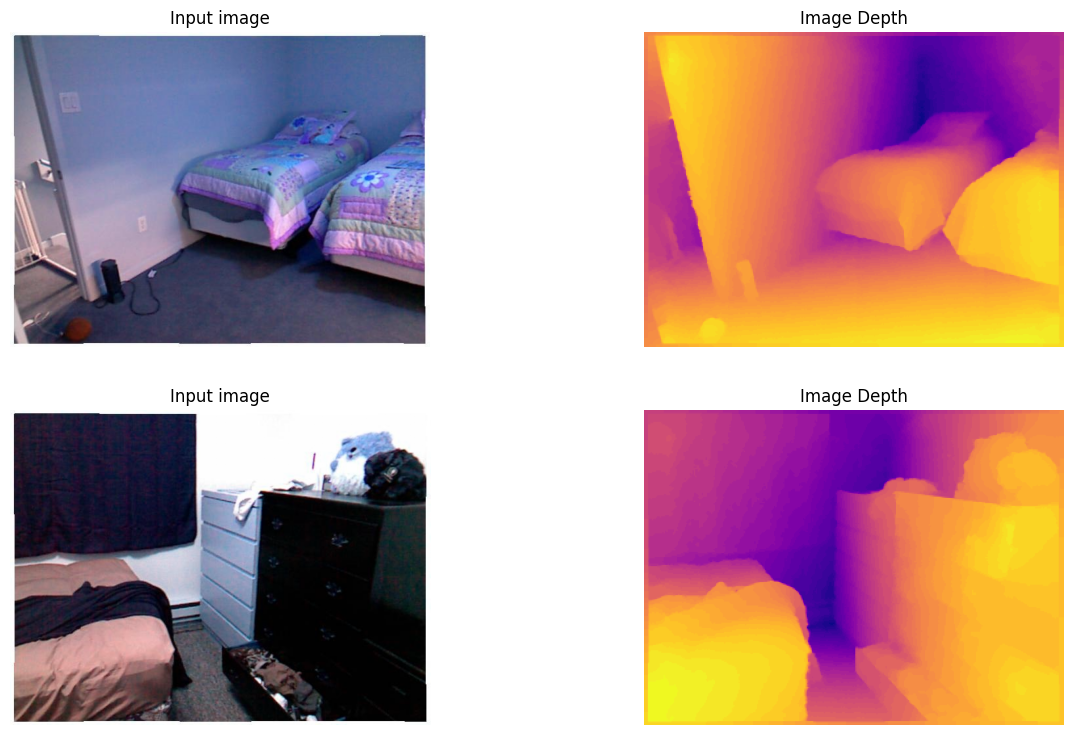

In [ ]:
images,depths = next(iter(train_generator))
print(images.shape, depths.shape)

cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i]
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Image Depth')

# **Training Process**

## **Model Building**

**Encoder**

In [10]:
def Encoder(width, height):
  encoder = DenseNet121(include_top=False, weights='imagenet', input_shape=(height,width,3))
  for layer in encoder.layers:
    layer.trainable = True
  return encoder

**Decoder**

In [11]:
def Upsampling(data, n_filters, concat_layer):
  dec = UpSampling2D(size=(2,2), interpolation='bilinear')(data)
  dec = BatchNormalization()(Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(concatenate([dec,concat_layer])))
  dec = BatchNormalization()(Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(dec))
  return dec

In [12]:
def Decoder(encoder):
  n_filters = 1024
  names_layers_encoder = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
  dec = Conv2D(filters=n_filters, kernel_size=(1,1), padding='same')(encoder.output)
  dec = LeakyReLU(alpha=0.2)(dec)
  dec = Upsampling(dec, n_filters/2, encoder.get_layer(names_layers_encoder[0]).output)
  dec = LeakyReLU(alpha=0.2)(dec)
  dec = Upsampling(dec, n_filters/4, encoder.get_layer(names_layers_encoder[1]).output)
  dec = LeakyReLU(alpha=0.2)(dec)
  dec = Upsampling(dec, n_filters/8, encoder.get_layer(names_layers_encoder[2]).output)
  dec = LeakyReLU(alpha=0.2)(dec)
  dec = Upsampling(dec, n_filters/16, encoder.get_layer(names_layers_encoder[3]).output)
  dec = Conv2D(filters=1, activation='sigmoid', kernel_size=(3,3), padding='same')(dec)

  return dec

# **Create and Display the Model**

In [13]:
def create_model(width = 640, height = 480):
  encoder = Encoder(width, height)
  decoder = Decoder(encoder)
  return encoder, decoder


In [14]:
encoder, decoder = create_model()
model = Model(inputs = encoder.input, outputs = decoder)
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 486, 646, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 240, 320, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

**Define Accuracy and Loss Function**

In [15]:
def loss_function(real, pred):

  l_depth = tkb.mean(tkb.abs(pred - real), axis=-1)


  dy_true, dx_true = tf.image.image_gradients(real)
  dy_pred, dx_pred = tf.image.image_gradients(pred)
  l_edges = tkb.mean(tkb.abs(dy_pred - dy_true) + tkb.abs(dx_pred - dx_true), axis=-1)

  l_ssim = tkb.clip((1 - tf.image.ssim(real, pred, 1.0)) * 0.5, 0, 1)

  complete_loss = 0.1 * tkb.mean(l_depth) + tkb.mean(l_edges) + l_ssim
  return complete_loss

def accuracy_function(y_true, y_pred):
  return tkb.mean(tkb.equal(tkb.round(y_true), tkb.round(y_pred)))

**Setting Hyperparameter**

In [16]:
init_lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr, amsgrad=True)
epochs = 20

**Set Callbacks and Learning Rate Scheduler**

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Depth_Estimation_UNet/saved_model/model.h5', save_weights_only=True, verbose=1)
adaptive_lr = tf.keras.optimizers.schedules.ExponentialDecay(init_lr,decay_steps=100000,decay_rate=0.96,staircase=True)
callbacks = [LearningRateScheduler(adaptive_lr, verbose=1), checkpoint]

**Start Training**

In [18]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy_function])
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs,callbacks=callbacks)

**Save Final Model**

In [ ]:
model.save('/content/drive/MyDrive/Depth_Estimation_UNet/saved_model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Evaluate Test Accuracy**

In [20]:
model.evaluate(test_generator)

81/81 [==============================] - 344s 4s/step - loss: 0.1668 - accuracy_function: 0.8130


[0.16679777204990387, 0.8129608035087585]

**Visualize Graph**

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
history.history['accuracy_function']
plt.plot(history.history['val_accuracy_function'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Load the TGest Data**

In [23]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

1/1 [==============================] - 6s 6s/step


**Predict Using Newly Trained Model**

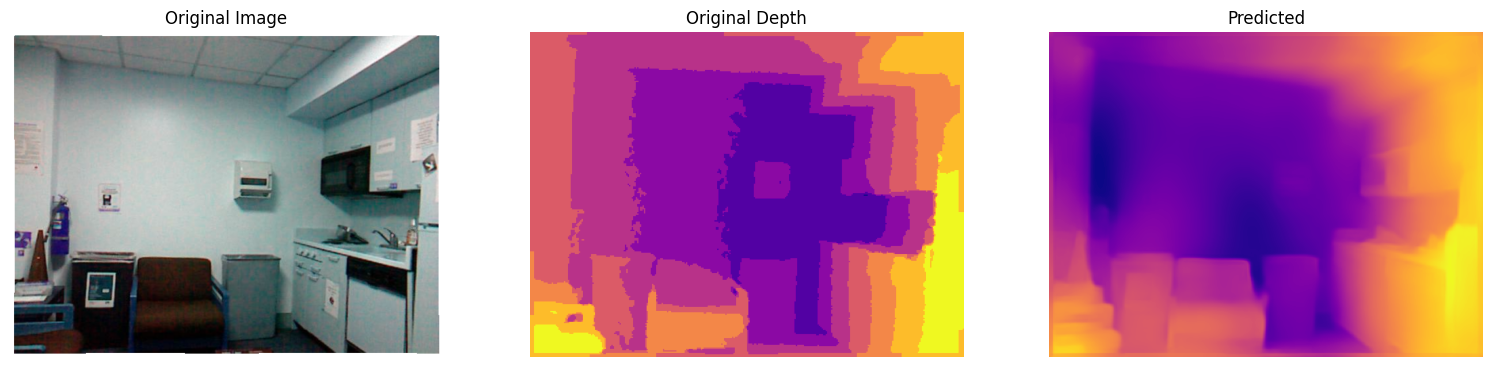

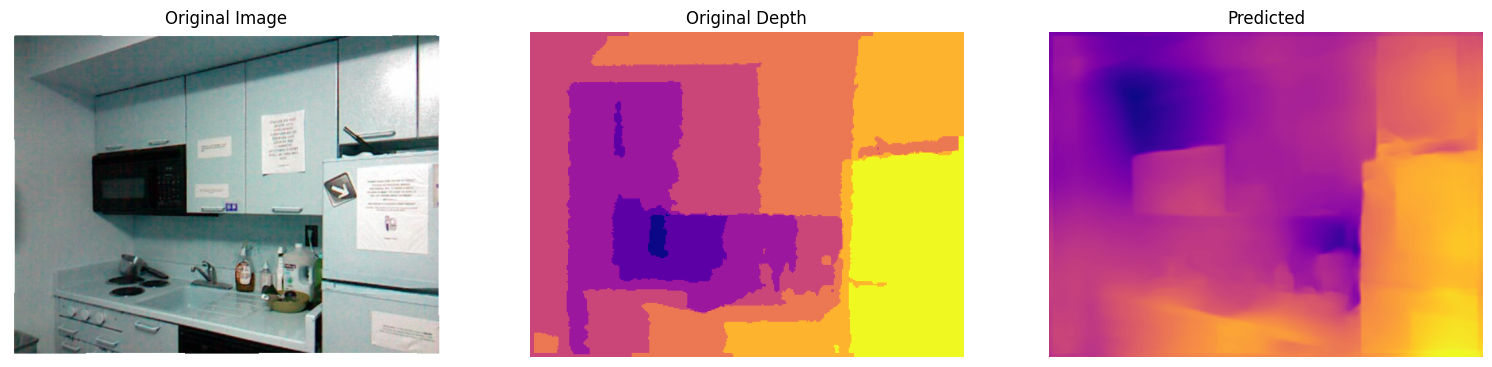

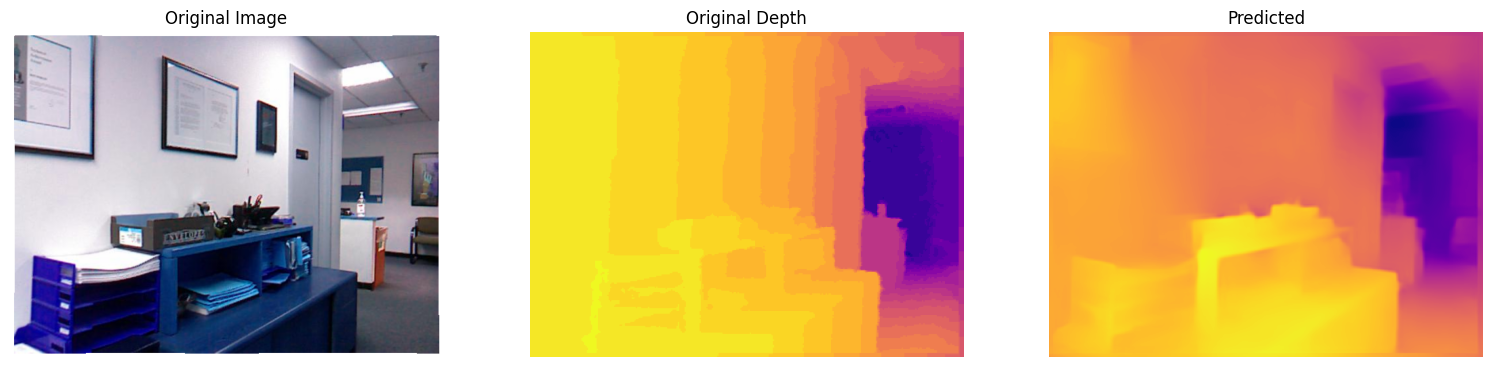

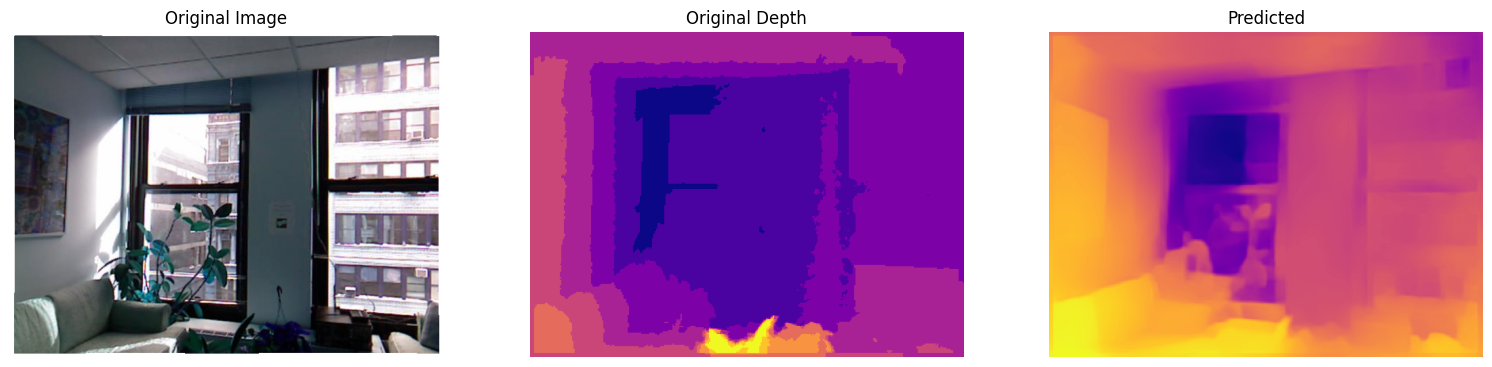

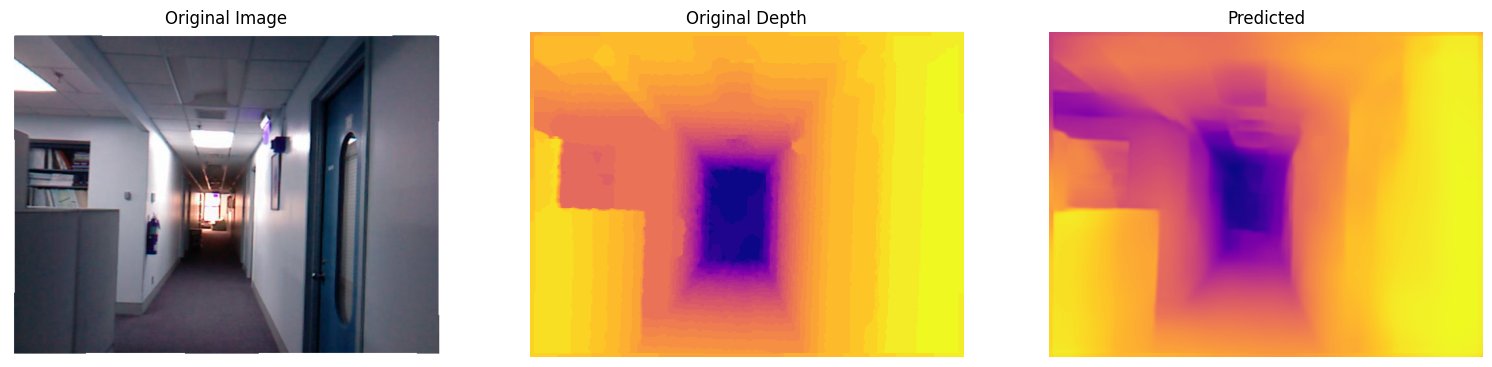

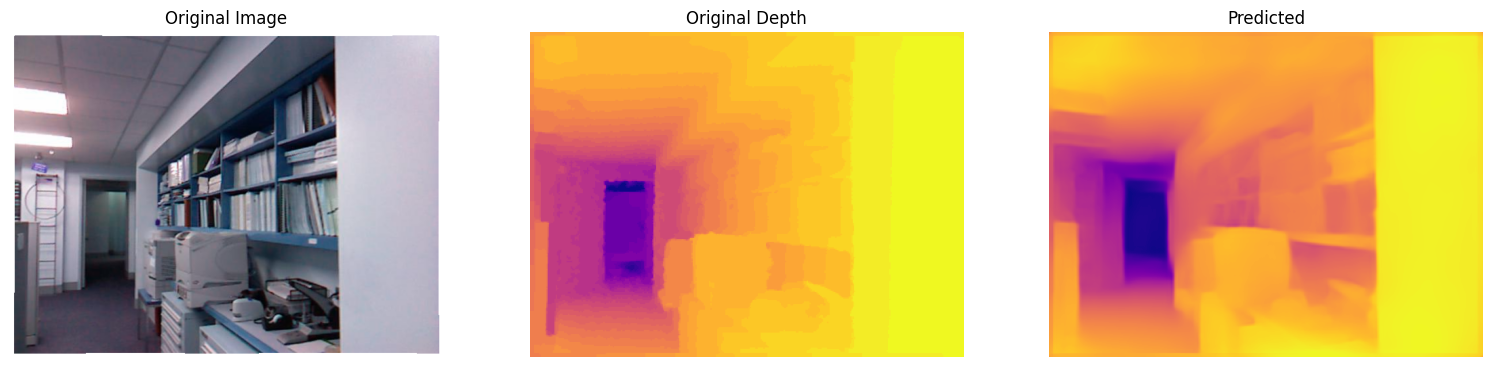

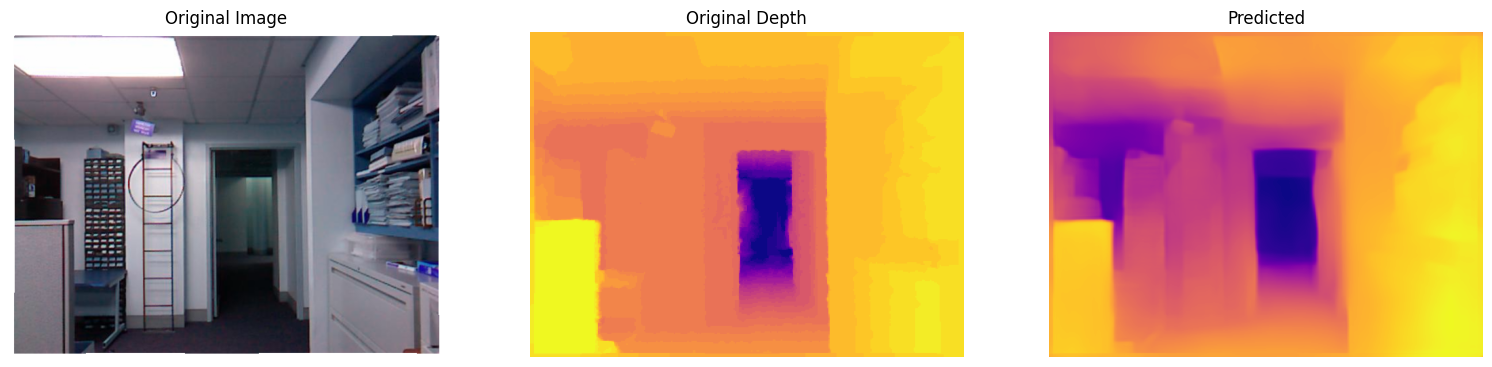

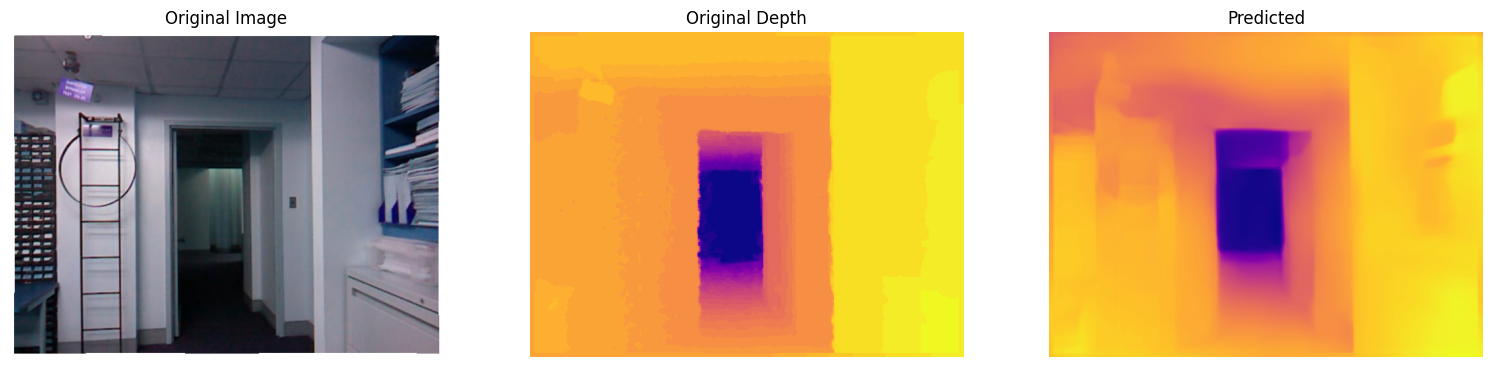

In [24]:
cmap = "plasma_r"

for i in range(len(images)):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.title('Original Image')
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)


  plt.subplot(1,3,2)
  plt.title('Original Depth')
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.title('Predicted')
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))


  plt.show()

# **Load and Test the Model**

#### Run the **Model build** Cells to create the model first

In [19]:
model.load_weights('/content/drive/MyDrive/Depth_Estimation_UNet/saved_model/model.h5')

#### **Load test Images**

#### Run the **Generator Class** Cell first

In [ ]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

**Visualize the results**

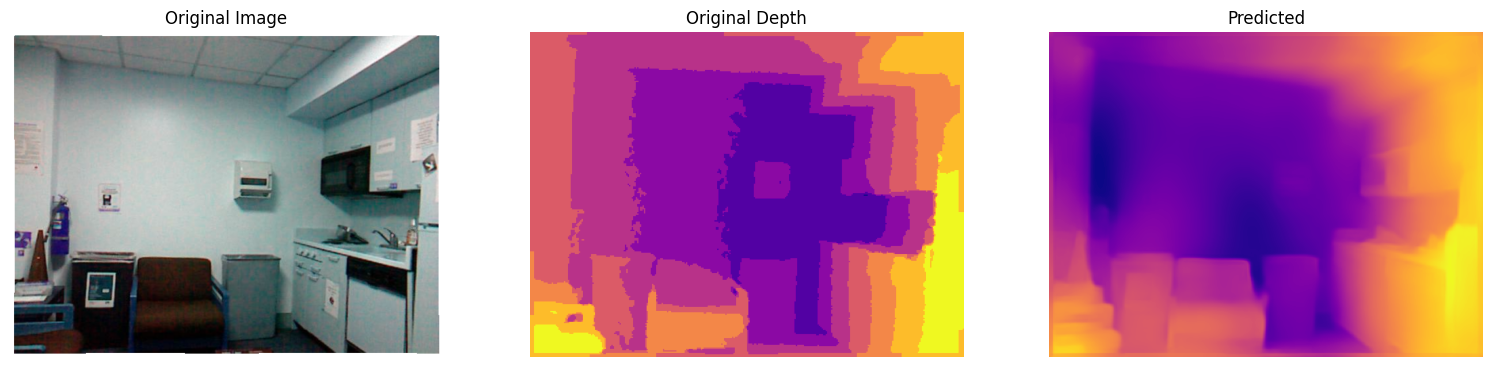

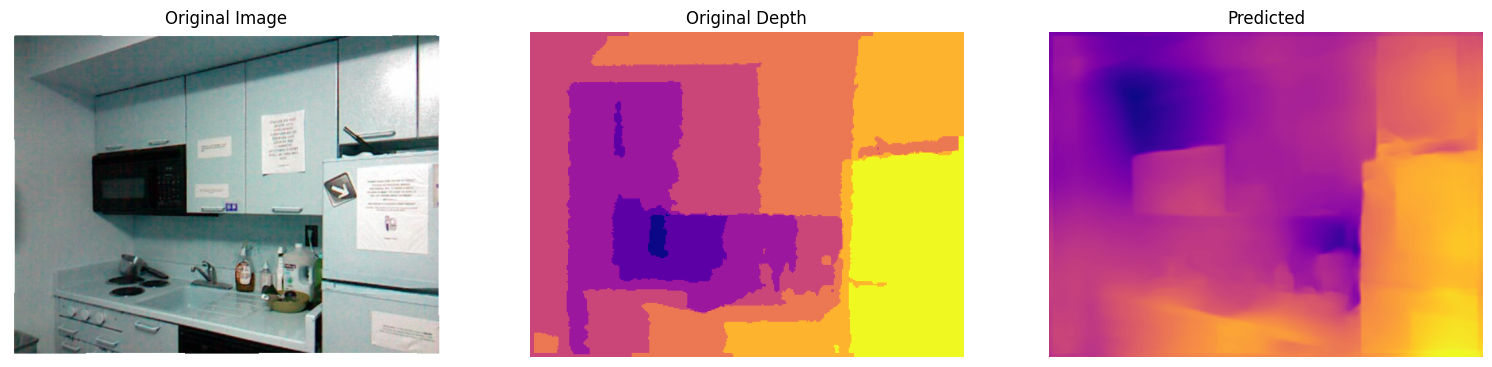

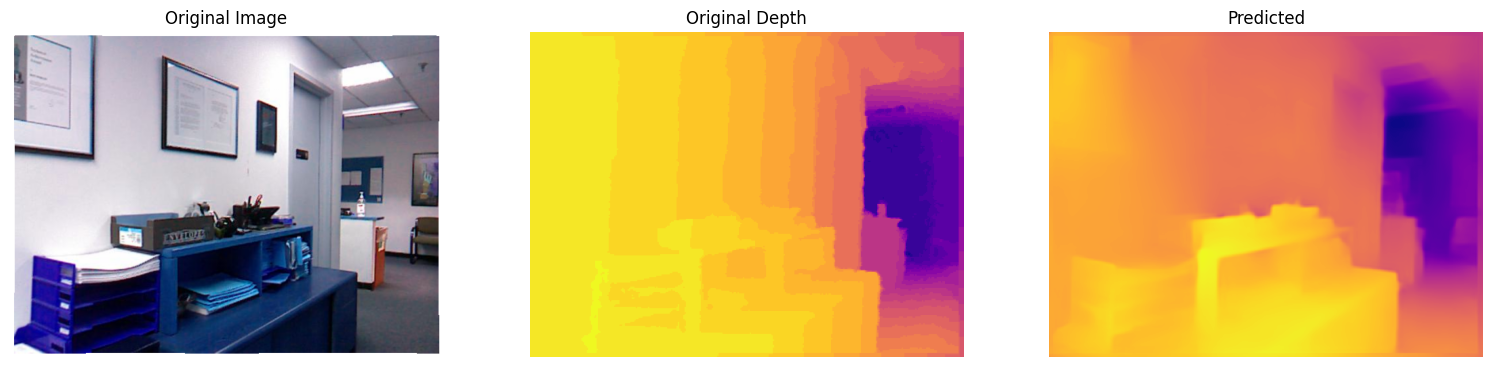

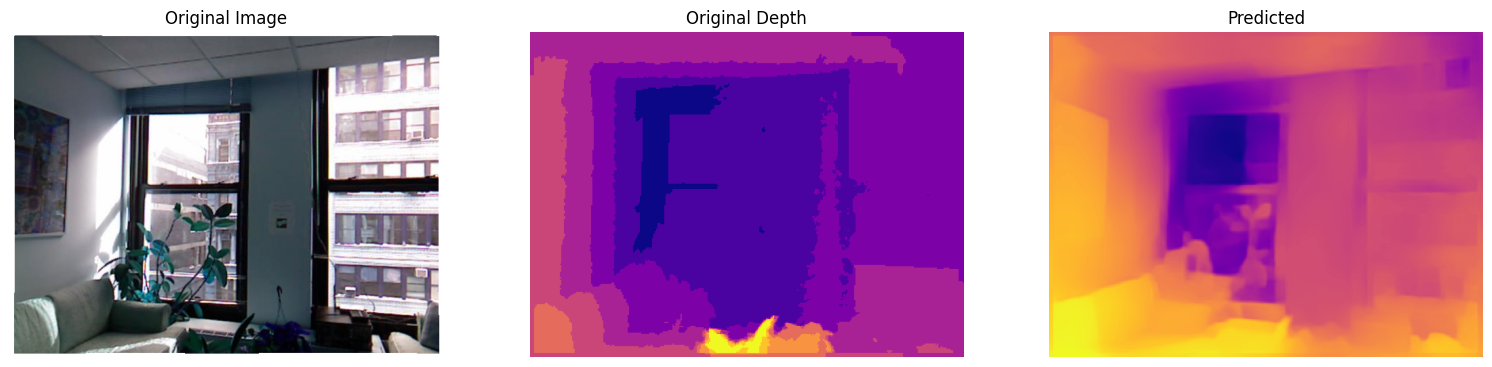

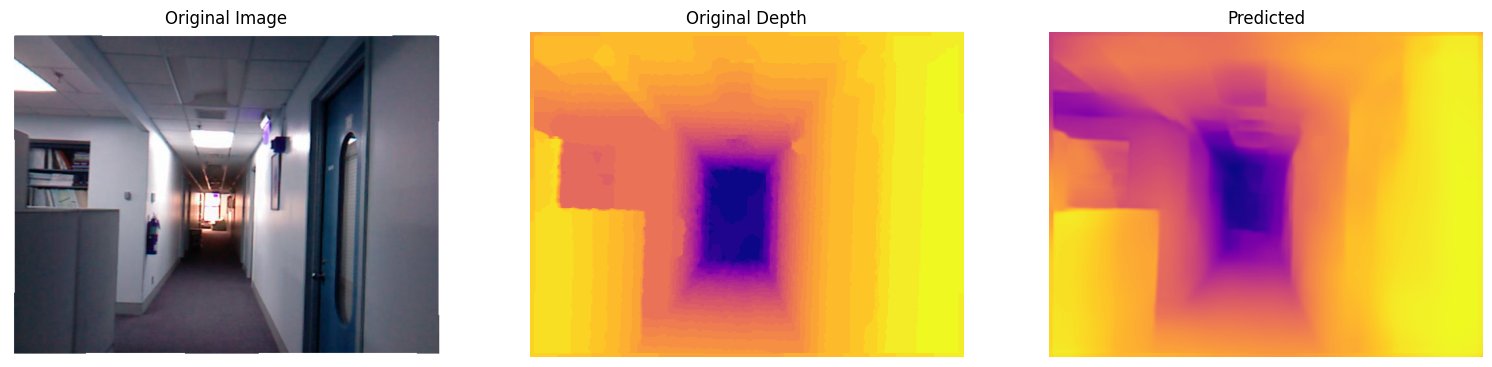

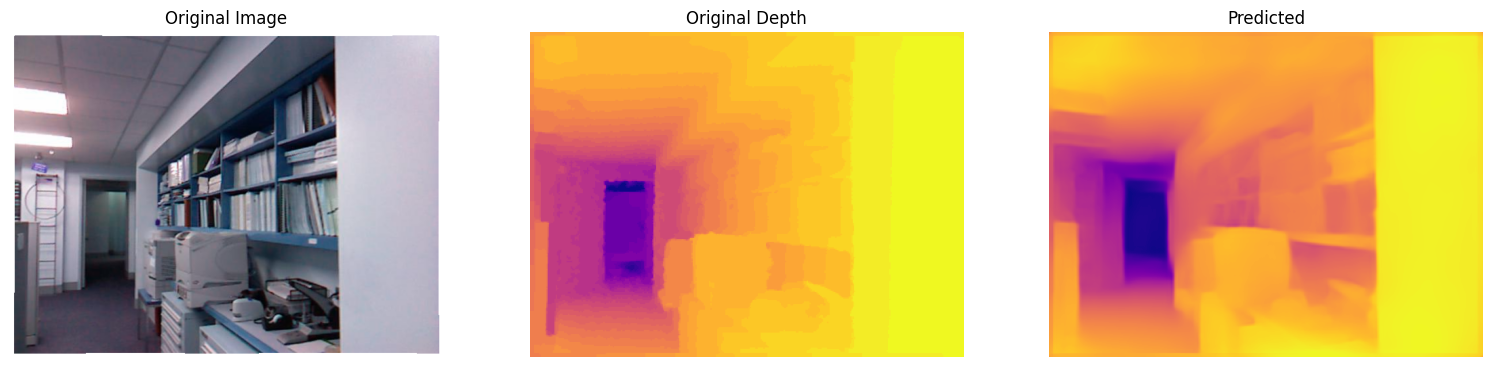

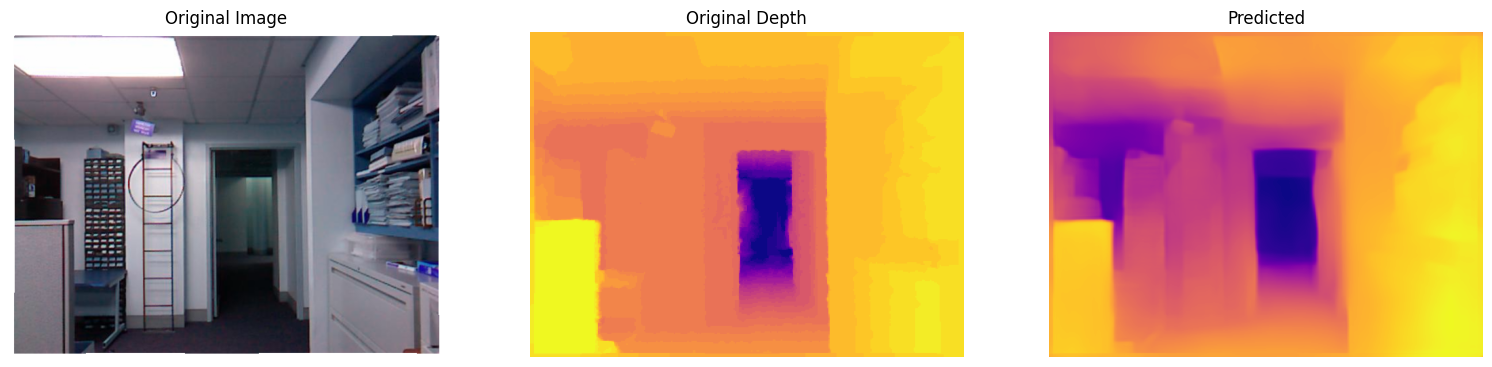

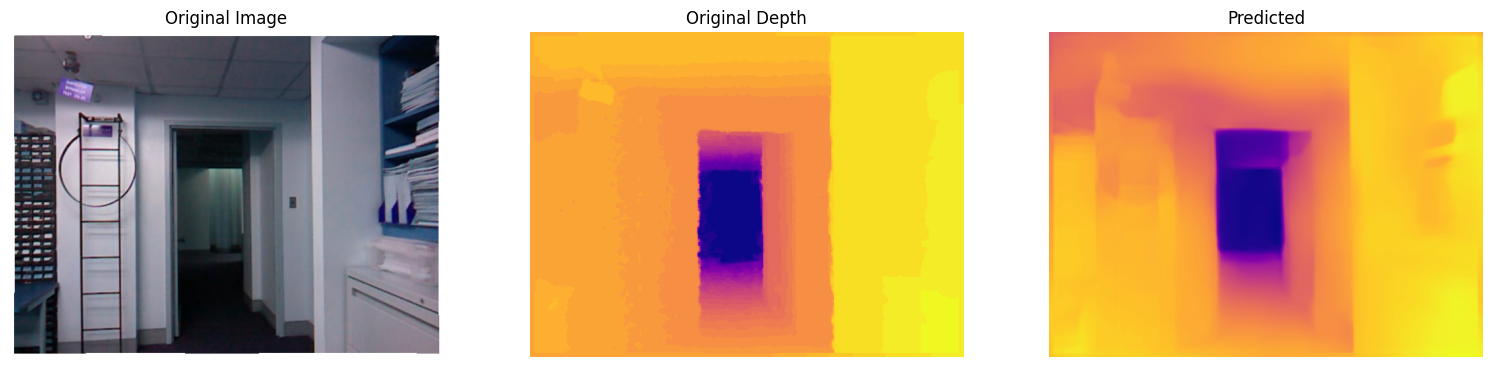

In [25]:
cmap = "plasma_r"

for i in range(len(images)):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.title('Original Image')
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)


  plt.subplot(1,3,2)
  plt.title('Original Depth')
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.title('Predicted')
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))


  plt.show()